# Example usage of the IEA Task 43 Digital Calibration Certificate Schema

This notebook is intended to give an overview on the IEA Task 43 digital calibration certificate schema for anemometer calibrations according to IEC61400-12-1:2017. It is intended for end-users and will show you how to load the data and make something usefull with it.

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import json
import jsonschema  # only used for validation
from collections import namedtuple
import warnings
warnings.filterwarnings('ignore')

# Loading the data
We first load the calibration certficate and verify that it's fulfilling the defined schema. Loading a JSON-file is easy and will return a dict-object:

In [2]:
dcc_filepath = r'..\\demo_data\\anemometer_calibration_certificate.json'
schema_filepath = r'..\\schema\\iea43_digital_calibration_certificate.schema.json'

with open(dcc_filepath, 'r') as f:
    sample_cal = json.load(f) 
with open(schema_filepath, 'r') as f:
    calibration_schema = json.load(f) 

# this step is optional
try:
    jsonschema.validate(sample_cal, calibration_schema)
except jsonschema.ValidationError as e:
    print("Sample data is INVALID!")
    raise e


# Meta data
Now that we know that the data is valid, lets explore it a little bit. The format is pretty much self-explenatory. We start with some meta data

In [3]:
sample_cal['calibration_id']

'2110000'

In [4]:
sample_cal['calibration_lab']

{'accreditation_id': 'D-K-15140-01-00',
 'company_name': 'Deutsche WindGuard Wind Tunnel Services GmbH',
 'address': 'Oldenburger Str. 65, DE-26123 Varel',
 'reference': 'VTXXXXXX'}

In [5]:
sample_cal['customer']

{'company_name': 'Example Customer',
 'address': 'Example Customer Address',
 'reference': 'Example Ordercode'}

# Test Item
Information about the calibrated wind sensor can be found in the 'test_item' field:

In [6]:
sample_cal['test_item']

{'model': 'Example Anemometer',
 'serial_number': 'Example Serial Number',
 'description': 'Cup Anemometer',
 'oem': {'company_name': 'Example Manufacturer',
  'address': 'Example Manufacturer Address'}}

# Calibration Setup
The format contains information on how the calibration was set-up. This part for example contains the calibration date, information about the mounting of the instrument, additional notes about the calibration and also introduces the **Quantity** datatype also used for the calibration result.

In [7]:
sample_cal['setup']['mounting_diameter']

{'value': 33.7, 'unit': 'mm'}

This is a **Quantity**. All numbers inside the format are Quantities. Quantities have two guaranteed fields: 'value' and 'unit' but can additionally hold information about an associated uncertainty and its coverage factor. To make working with this datatype easier, lets make this a class:

In [8]:
Quantity = namedtuple('Quantity', 'value, unit, uncertainty, k')

def quantity_from_dict(quantity_dict):
    '''
    returns a Quantity object created from a dict containing.
    '''
    value = quantity_dict['value']
    unit = quantity_dict['unit']
    if 'uncertainty' in quantity_dict:
        uncertainty = quantity_dict['uncertainty']['value']
        coverage_factor = quantity_dict['uncertainty']['coverage_factor']
    else:
        uncertainty = np.nan
        coverage_factor = np.nan
    return Quantity(value, unit, uncertainty, coverage_factor)

mounting_diameter = quantity_from_dict(sample_cal['setup']['mounting_diameter'])
mounting_diameter.value

33.7

# Calibration Result
Now let's have a look at the calibration result table:

In [9]:
sample_cal['result']['table']

[{'index': '1',
  'reference': {'value': 3.936,
   'unit': 'm/s',
   'uncertainty': {'value': 0.05, 'coverage_factor': 2}},
  'test_item': {'value': 80.67,
   'unit': 'Hz',
   'uncertainty': {'value': 0.2, 'coverage_factor': 2}},
  'deviation': {'value': -0.009,
   'unit': 'm/s',
   'uncertainty': {'value': 0.051, 'coverage_factor': 2}}},
 {'index': '2',
  'reference': {'value': 6.088,
   'unit': 'm/s',
   'uncertainty': {'value': 0.05, 'coverage_factor': 2}},
  'test_item': {'value': 127.6,
   'unit': 'Hz',
   'uncertainty': {'value': 0.3, 'coverage_factor': 2}},
  'deviation': {'value': -0.01,
   'unit': 'm/s',
   'uncertainty': {'value': 0.052, 'coverage_factor': 2}}},
 {'index': '3',
  'reference': {'value': 8.136,
   'unit': 'm/s',
   'uncertainty': {'value': 0.05, 'coverage_factor': 2}},
  'test_item': {'value': 172.15,
   'unit': 'Hz',
   'uncertainty': {'value': 0.41, 'coverage_factor': 2}},
  'deviation': {'value': -0.005,
   'unit': 'm/s',
   'uncertainty': {'value': 0.053, '

As you can see, we need to convert the data into something more tabular and useful. In it's current form, the data is split into an array of dictionarys which represent the rows of a table. Each row contains the data represented by Quantities. Here is an example on how to convert the data into a pandas.DataFrame:

In [10]:
def result_table_from_dict(result_table_dict):
    '''
    returns a pandas.DataFrame created from a dict containing a result table.
    '''
    table_data = []
    for row in result_table_dict:
        index = row['index']
        reference = quantity_from_dict(row['reference'])
        test_item = quantity_from_dict(row['test_item'])
        deviation = quantity_from_dict(row['deviation'])
        table_data.append([index, reference.value, reference.uncertainty, test_item.value, test_item.uncertainty, deviation.value, deviation.uncertainty])
    df = pd.DataFrame(table_data, columns=['Index', 'Reference', 'Reference_Uncertainty', 'Test_Item', 'Test_Item_Uncertainty', 'Deviation', 'Deviation_Uncertainty'])
    df = df.set_index('Index')
    return df

result_table = result_table_from_dict(sample_cal['result']['table'])
result_table

,Reference,Reference_Uncertainty,Test_Item,Test_Item_Uncertainty,Deviation,Deviation_Uncertainty
Index,,,,,,
1,3.936,0.050,80.67,0.20,-0.009,0.051
2,6.088,0.050,127.60,0.30,-0.010,0.052
3,8.136,0.050,172.15,0.41,-0.005,0.053
4,9.994,0.050,211.91,0.49,0.028,0.055
5,11.975,0.060,255.10,0.52,0.028,0.064
6,13.941,0.070,298.31,0.54,0.012,0.074
7,16.019,0.080,344.26,0.76,-0.018,0.087
8,14.969,0.075,321.48,0.62,-0.023,0.080
9,12.941,0.065,276.94,0.56,-0.008,0.070


Let's have a look at the data:

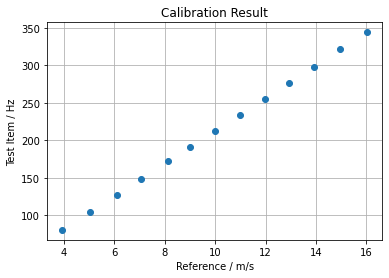

In [14]:
 %matplotlib inline

plt.title('Calibration Result')
plt.plot(result_table['Reference'], result_table['Test_Item'], 'o')
plt.xlabel('Reference / {}'.format(sample_cal['result']['table'][0]['reference']['unit']))
plt.ylabel('Test Item / {}'.format(sample_cal['result']['table'][0]['test_item']['unit']))
plt.grid()


If only the reference, test item output and the uncertainty is given, we can easily calculate the deviation (or residuals) ourself. For this we use the **slope** and **offset** given in the 'linear_regression' field of the 'result':

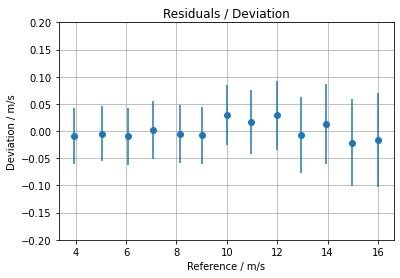

In [17]:
%matplotlib inline
# example for direct access to a quantity.
slope = sample_cal['result']['linear_regression']['slope']['value']
# example for usage with the Quantity class. With this we have full access to all attributes
offset = quantity_from_dict(sample_cal['result']['linear_regression']['offset'])
test_item_ms = slope * result_table['Test_Item'] + offset.value
plt.title('Residuals / Deviation')
plt.errorbar(result_table['Reference'], result_table['Reference'] - test_item_ms, yerr=result_table['Deviation_Uncertainty'], fmt='o')
plt.xlabel('Reference / {}'.format(sample_cal['result']['table'][0]['reference']['unit']))
plt.ylabel('Deviation / {}'.format(sample_cal['result']['table'][0]['deviation']['unit']))
plt.ylim(-0.2, +0.2)
plt.grid()